# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from sklearn.metrics import silhouette_score
from tqdm import tqdm

import umap

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')

import splicing_utils


-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.0
anndata             0.7.4
autoreload          NA
backcall            0.2.0
cffi                1.14.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.17.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.34.0
louvain             0.7.0
matplotlib          3.3.2
mpl_toolkits        NA
natsort             7.0.1
numba               0.51.2
numexpr             2.7.1
numpy               1.19.2
packaging           20.4
pandas              1.1.3
parso               0.7.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptyprocess          0.6.0
pycparser           2.20
pygments            2.7.1
pyparsin

## Data folder

In [2]:
splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 1.5G
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 .
drwxr-xr-x 7 olga czb 4.0K Oct 13 10:48 ..
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 concatenated
-rw-r--r-- 1 olga czb 690M Oct 13 10:15 TSP1_10x_nopanc_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 803M Oct 13 10:14 TSP2_10x_3prime_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq


## 2d splicing data

In [3]:
concatenated_splicing_folder = f'{splicing_folder}/concatenated'
! ls -lha  $concatenated_splicing_folder

total 699M
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 .
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 ..
-rw-r--r-- 1 olga czb  21M Oct 13 11:05 tabula_sapiens_10x_splicing_2d.parquet
-rw-r--r-- 1 olga czb 679M Oct 13 11:05 tabula_sapiens_10x_splicing_tidy.parquet


## Read h5ad

### Try new adata

In [4]:
# h5ad = '/home/olga/Pilot1_Pilot2_filtered_ensembl_id_Aug5.ss2_norm.ann.compartment.allgenes.h5ad'

# Newest, freshest data
h5ad2 = '/home/olga/data_sm/tabula-sapiens/data-objects/Pilot1_Pilot2.decontX.h5ad'
adata = sc.read(h5ad2)
adata

AnnData object with n_obs × n_vars = 150084 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_metho

### Clean to only 10x data and clean the cell id

In [6]:
adata_10x = adata[adata.obs.method == "10X"]
adata_10x.obs = adata_10x.obs.set_index('cell_id')
adata_10x.obs.head()

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTGTAGCAG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.014378,TSP110X-macrophage,NaN,NaN,0.000493,2,0,9.285843,0.678913
AAACCCATCAAGTCTG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.087799,TSP110X-macrophage,NaN,NaN,0.001835,2,0,9.285843,0.678913
AAACCCATCCTTCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.015747,TSP110X-macrophage,NaN,NaN,0.000560,2,0,9.285843,0.678913
AAACCCATCGAAGGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.006901,TSP110X-macrophage,NaN,NaN,0.000383,2,0,9.285843,0.678913
AAACGAAAGCTCCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.460883,TSP110X-plasma cell,NaN,NaN,0.017516,2,0,9.285843,0.678913


## Read 2d splicing matrix

In [7]:
splicing2d = pd.read_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_10x_splicing_2d.parquet')
# Update cell ids
# splicing2d.index = splicing2d.index.str.rstrip('_0123456789')
print(splicing2d.shape)
splicing2d.head()

(59367, 1617)


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
adata_10x.obs.head()

,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTGTAGCAG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.014378,TSP110X-macrophage,NaN,NaN,0.000493,2,0,9.285843,0.678913
AAACCCATCAAGTCTG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.087799,TSP110X-macrophage,NaN,NaN,0.001835,2,0,9.285843,0.678913
AAACCCATCCTTCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.015747,TSP110X-macrophage,NaN,NaN,0.000560,2,0,9.285843,0.678913
AAACCCATCGAAGGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.006901,TSP110X-macrophage,NaN,NaN,0.000383,2,0,9.285843,0.678913
AAACGAAAGCTCCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.460883,TSP110X-plasma cell,NaN,NaN,0.017516,2,0,9.285843,0.678913


## Get a comon indx of shared cells

In [16]:
common_index = splicing2d.index.intersection(adata_10x.obs.index)
len(common_index)

52697

### Subset the adata

In [22]:
adata_with_splicing = adata_10x[common_index]
print(adata_with_splicing)
adata_with_splicing.obs.head()

View of AnnData object with n_obs × n_vars = 52697 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,TSP1_muscle_2,nan,nan,nan,nan,nan,10X,TSP1,2,novaseq,...,TSP110X,0.010015,TSP110X-skeletal muscle satellite stem cell,NaN,NaN,0.000411,2,0,9.285843,0.678913
AAACCCAAGCAACAGC_TSP1_blood_3,TSP1_blood_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.004977,TSP110X-T cell,NaN,NaN,0.000356,2,0,9.285843,0.678913
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,TSP2_Blood_NA_10X_2_1,nan,nan,nan,nan,nan,10X,TSP2,1,novaseq,...,TSP210X,0.055971,TSP210X-natural killer cell,NaN,NaN,0.001357,3,0,8.848207,0.482012
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,TSP2_Blood_NA_10X_1_3,nan,nan,nan,nan,nan,10X,TSP2,3,novaseq,...,TSP210X,0.002236,TSP210X-non-classical monocyte,NaN,NaN,0.000100,3,0,8.848207,0.482012
AAACCCAAGCATCAGG_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.001521,TSP110X-macrophage,NaN,1.0,0.000165,2,0,9.285843,0.678913


### Subset the splicing data

In [25]:
splicing2d_common = splicing2d.loc[common_index]
print(splicing2d_common.shape)
splicing2d_common

(52697, 1617)


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTATCGGA_TSP2_Lung_proxmedialdistal_10X_1_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCTCATGGA_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCTGAGATC_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SUbset ot just muslce

In [32]:
adata_with_splicing_muscle = adata_with_splicing[adata_with_splicing.obs.tissue == "Muscle"]
adata_with_splicing_muscle

View of AnnData object with n_obs × n_vars = 12200 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 

In [33]:
splicing2d_muscle = splicing2d.loc[adata_with_splicing_muscle.obs.index]
splicing2d_muscle.shape

(12200, 1617)

## filter splicing data

### Filter on number of cells per gene

count     1617.000000
mean       542.656153
std       2000.050795
min          0.000000
25%          0.000000
50%          3.000000
75%         56.000000
max      11875.000000
dtype: float64


/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

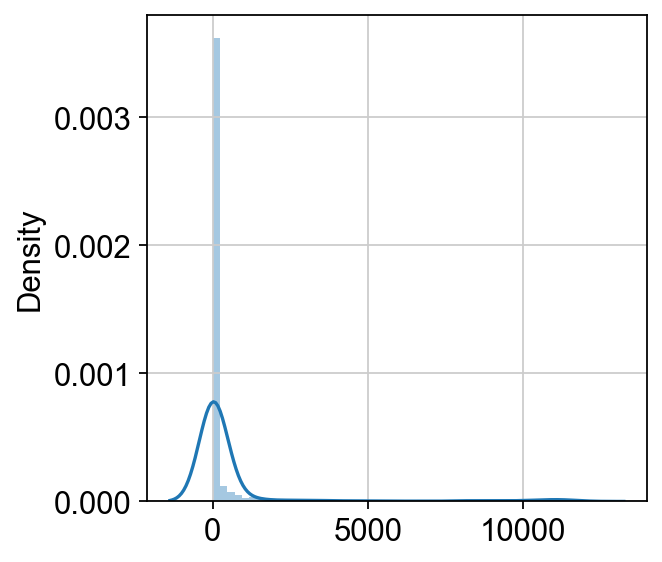

In [40]:
n_cells_per_gene = splicing2d_muscle.notnull().sum()
print(n_cells_per_gene.describe())
sns.distplot(n_cells_per_gene)

count    12200.000000
mean        71.924180
std         31.345033
min          1.000000
25%         57.000000
50%         71.000000
75%         84.000000
max        428.000000
dtype: float64


/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

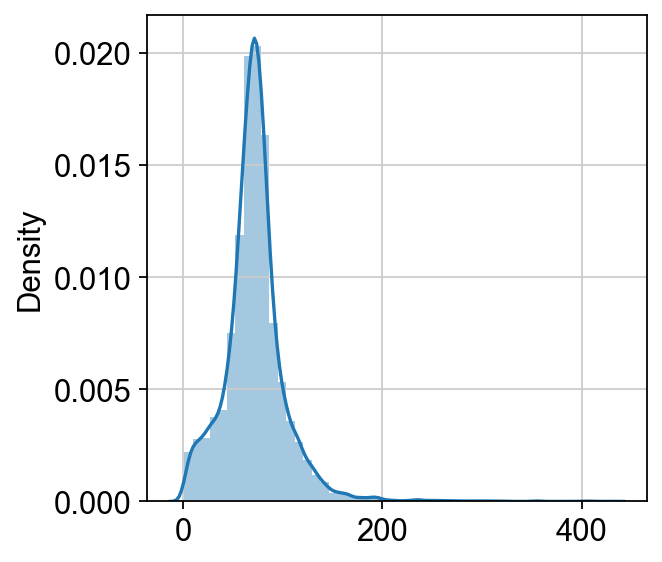

In [41]:
n_genes_per_cell = splicing2d_muscle.notnull().sum(axis=1)
print(n_genes_per_cell.describe())
sns.distplot(n_genes_per_cell)

In [55]:
splicing2d_muscle_min_genes_cells = splicing2d_muscle.loc[n_genes_per_cell >= 75, n_cells_per_gene >= 5]
splicing2d_muscle_min_genes_cells.shape

(5122, 768)

## Subset adata to only cells with enough splicing

In [71]:
adata_with_splicing_subset = adata_with_splicing_muscle[splicing2d_muscle_min_genes_cells.index]
adata_with_splicing_subset

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 5122 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', '

## SKIP - Subsample to 50% of data

In [57]:
# splicing2d_muscle_min_genes_cells_subset = splicing2d_muscle_min_genes_cells.sample(frac=0.5)
# splicing2d_subset.shape

In [72]:
adata_with_splicing_subset.obs.groupby(['donor', 'tissue']).size()

donor  tissue
TSP1   Muscle    1449
TSP2   Muscle    3673
dtype: int64

In [73]:
adata_with_splicing_subset.obs.groupby(['donor', 'tissue', 'Propagated.Annotationcollapsed'], observed=True).size()

donor  tissue  Propagated.Annotationcollapsed        
TSP1   Muscle  skeletal muscle satellite stem cell        185
               capillary endothelial cell                 205
               mesenchymal stem cell                      500
               endothelial cell of lymphatic vessel         9
               macrophage                                  43
               endothelial cell of vascular tree          250
               tendon cell                                 46
               slow muscle cell                            16
               pericyte cell                              107
               fast muscle cell                            41
               mesenchymal cell                            13
               endothelial cell of artery                  13
               T cell                                      20
               B cell                                       1
TSP2   Muscle  skeletal muscle satellite stem cell        260
               c

In [ ]:
%%time

splicing2d_subset_distances = splicing_utils.compute_distances_df(splicing2d_muscle_min_genes_cells, n_jobs=32)
print(splicing2d_subset_distances.shape)
splicing2d_subset_distances.head()

Created memmapped input matrix
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap


# Do UMAP

In [64]:
%%time

umapper = umap.UMAP(metric='precomputed', verbose=True)
umapped = umapper.fit_transform(splicing2d_subset_distances)
umapped.shape

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


UMAP(metric='precomputed', verbose=True)
Construct fuzzy simplicial set
Mon Oct 26 13:35:46 2020 Finding Nearest Neighbors
Mon Oct 26 13:35:46 2020 Finished Nearest Neighbor Search
Mon Oct 26 13:35:47 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Oct 26 13:35:58 2020 Finished embedding
CPU times: user 13min 39s, sys: 32.7 s, total: 14min 12s
Wall time: 12.8 s


(5122, 2)

In [65]:
umapped.shape

(5122, 2)

In [67]:
adata_with_splicing_subset.obsm['X_umap_splicing'] = umapped

## Plot UMAP

In [ ]:
# adata_with_splicing_subset.uns['']

In [ ]:
UMAP_COLOR = ['tissue', 'compartment_pred_svm', 'donor']

sc.pl.embedding(adata_with_splicing_subset, basis='X_umap_splicing', color=UMAP_COLOR)
sc.pl.embedding(adata_with_splicing_subset, basis='X_umap_splicing', color='Propagated.Annotationcollapsed')

# BBKNN

## BBKNN on expression data

In [ ]:
sc.tl.pca(adata, n_comps=200)

In [ ]:
sc.external.pp.bbknn(adata, batch_key='donor')

## Function to compute silhouette scores

In [ ]:
def compute_silhoutte_vs_col(adata, silhouette_cols, umapped, label, metric='euclidean', n_iter=100):
    lines = []
    sample_size = int(umapped.shape[0]/2)
    for i in tqdm(range(n_iter)):
        for col in silhouette_cols: 
            silhouette = silhouette_score(umapped, adata.obs[col], metric=metric, sample_size=sample_size, 
                                          random_state=i)
            lines.append([label, col, silhouette, i])
    df = pd.DataFrame(lines, columns=['label', 'group', 'silhoutte_score', 'iteration'])
    return df

In [ ]:
silhouette_cols = UMAP_COLOR + ['Propagated.Annotationcollapsed']

### Compute silhouette on KNN distances of graph

In [ ]:
%%time

silhouette_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, adata_with_splicing_subset.uns['connectivities'], label='bbknn_distances', metric='precomputed'
)
silhouette_bbknn

### Comput silhouette on splicing distances

In [ ]:
%%time

silhouette_splicing = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, splicing2d_subset_distances, label='splicing_distances', metric='precomputed'
)
silhouette_splicing

In [ ]:
%%time

silhouette_scvi = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, adata_with_splicing_subset.obsm['X_scvi'], label='expression_scvi', 
)
silhouette_scvi

### SKIP - Calculating on expression values takes too long - can't even complete 1 iteration in a reasonable time (<1h)

In [ ]:
# %%time

# silhouette_genes = compute_silhoutte_vs_col(
#     adata_with_splicing_subset, 
#     silhouette_cols, 
#     adata_with_splicing_subset.X, 
#     label='expression_euclidean', 
#     metric='euclidean',
#     n_iter=10,
# )
# silhouette_genes

## Concatenate silhouette scores

In [ ]:
silhoutte_concatenated = pd.concat(
    [
        silhouette_splicing, 
#         silhouette_scvi, 
        silhouette_genes
    ]
)
print(silhoutte_concatenated.shape)
silhoutte_concatenated.head()

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated,
    kind='box',
)

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='group',
    col='label',
    data=silhoutte_concatenated,
    kind='box',
)

## bbknn_utils.py

In [ ]:
%%file bbknn_utils.py
from typing import Optional, Union


import numpy as np
from scipy.spatial import cKDTree
import bbknn
from scipy.sparse import csr_matrix
import scanpy as sc
from numpy.testing import assert_array_equal, assert_array_compare
import operator


import numpy as np
from anndata import AnnData
from sklearn.utils import check_random_state, check_array

from scanpy.tools._utils import get_init_pos_from_paga#, _choose_representation
from scanpy import logging as logg
from scanpy._settings import settings
from scanpy._compat import Literal
from scanpy._utils import AnyRandom, NeighborsView


# Lots of this was stolen from https://github.com/theislab/scanpy/blob/master/scanpy/tools/_umap.py
_InitPos = Literal['paga', 'spectral', 'random']


def make_graph_from_batch_corrected_distances(distances, batch_list, neighbors_within_batch, approx, metric, use_faiss, n_trees):
    '''
    Identify the KNN structure to be used in graph construction. All input as in ``bbknn.bbknn()``
    and ``bbknn.bbknn_pca_matrix()``. Returns a tuple of distances and indices of neighbours for
    each cell.
    '''
    #get a list of all our batches
    batches = np.unique(batch_list)
    #in case we're gonna be faissing, turn the data to float32
    if metric=='euclidean' and not approx and 'faiss' in sys.modules and use_faiss:
        pca = pca.astype('float32')
    #create the output matrices, with the indices as integers and distances as floats
    knn_distances = np.zeros((distances.shape[0],neighbors_within_batch*len(batches)))
    knn_indices = np.copy(knn_distances).astype(int)
    #find the knns using faiss/cKDTree/KDTree/annoy
    #need to compare each batch against each batch (including itself)
    for to_ind in range(len(batches)):
        #this is the batch that will be used as the neighbour pool
        #create a boolean mask identifying the cells within this batch
        #and then get the corresponding row numbers for later use
        batch_to = batches[to_ind]
        mask_to = batch_list == batch_to
        ind_to = np.arange(len(batch_list))[mask_to]
        #create the faiss/cKDTree/KDTree/annoy, depending on approx/metric
        ckd = bbknn.create_tree(data=distances[mask_to,:],approx=approx,metric=metric,
                          use_faiss=use_faiss,n_trees=n_trees)
        for from_ind in range(len(batches)):
            #this is the batch that will have its neighbours identified
            #repeat the mask/row number getting
            batch_from = batches[from_ind]
            mask_from = batch_list == batch_from
            ind_from = np.arange(len(batch_list))[mask_from]
            #fish the neighbours out, getting a (distances, indices) tuple back
            ckdout = bbknn.query_tree(data=distances[mask_from,:],ckd=ckd,
                                neighbors_within_batch=neighbors_within_batch,
                                approx=approx,metric=metric,use_faiss=use_faiss)
            #the identified indices are relative to the subsetted PCA matrix
            #so we need to convert it back to the original row numbers
            for i in range(ckdout[1].shape[0]):
                for j in range(ckdout[1].shape[1]):
                    ckdout[1][i,j] = ind_to[ckdout[1][i,j]]
            #save the results within the appropriate rows and columns of the structures
            col_range = np.arange(to_ind*neighbors_within_batch, (to_ind+1)*neighbors_within_batch)
            knn_indices[ind_from[:,None],col_range[None,:]] = ckdout[1]
            knn_distances[ind_from[:,None],col_range[None,:]] = ckdout[0]
    return knn_distances, knn_indices


def bbknn_distance_matrix(distances, batch_list, neighbors_within_batch=3, trim=None, 
          approx=True, n_trees=10, use_faiss=True, metric='angular', 
          set_op_mix_ratio=1, local_connectivity=1):
    '''
    Scanpy-independent BBKNN variant that runs on a PCA matrix and list of per-cell batch assignments instead of
    an AnnData object. Non-data-entry arguments behave the same way as ``bbknn.bbknn()``.
    Returns a ``(distances, connectivities)`` tuple, like what would have been stored in the AnnData object.
    The connectivities are the actual neighbourhood graph.
    
    Input
    -----
    pca : ``numpy.array``
        PCA (or other dimensionality reduction) coordinates for each cell, with cells as rows.
    batch_list : ``numpy.array`` or ``list``
        A list of batch assignments for each cell.
    '''
    #more basic sanity checks/processing
    #do we have the same number of cells in pca and batch_list?
    if distances.shape[0] != len(batch_list):
        raise ValueError("Different cell counts indicated by `distances.shape[0]` and `len(batch_list)`.")
    #convert batch_list to np.array of strings for ease of mask making later
    batch_list = np.asarray([str(i) for i in batch_list])
    #metric sanity checks (duplicating the ones in bbknn(), but without scanpy logging)
    if approx and metric not in ['angular', 'euclidean', 'manhattan', 'hamming']:
        print('unrecognised metric for type of neighbor calculation, switching to angular')
        metric = 'angular'
    elif not approx and not (metric=='euclidean' or isinstance(metric,DistanceMetric) or metric in KDTree.valid_metrics):
        print('unrecognised metric for type of neighbor calculation, switching to euclidean')
        metric = 'euclidean'
    #obtain the batch balanced KNN graph
    knn_distances, knn_indices = make_graph_from_batch_corrected_distances(
        distances, 
        batch_list=batch_list, 
        n_trees=n_trees,
        approx=approx,
        metric=metric,
        use_faiss=use_faiss,
        neighbors_within_batch=neighbors_within_batch)
    #sort the neighbours so that they're actually in order from closest to furthest
    newidx = np.argsort(knn_distances,axis=1)
    knn_indices = knn_indices[np.arange(np.shape(knn_indices)[0])[:,np.newaxis],newidx]
    knn_distances = knn_distances[np.arange(np.shape(knn_distances)[0])[:,np.newaxis],newidx] 
    #this part of the processing is akin to scanpy.api.neighbors()
    dist, cnts = bbknn.compute_connectivities_umap(knn_indices, knn_distances, knn_indices.shape[0], 
                                             knn_indices.shape[1], set_op_mix_ratio=set_op_mix_ratio,
                                             local_connectivity=local_connectivity)
    #trimming. compute default range if absent
    if trim is None:
        trim = 10 * knn_distances.shape[1]
    #skip trimming if set to 0, otherwise trim
    if trim > 0:
        cnts = bbknn.trimming(cnts=cnts,trim=trim)
    return (dist, cnts)


def assign_neighbors(ad, neighbors_key, knn_distances, knn_indices, set_use_rep=True):
    """Add bbknn-corrected neighbors to specific keybor key"""
    ad.uns[neighbors_key] = {}
    #we'll have a zero distance for our cell of origin, and nonzero for every other neighbour computed
    ad.uns[neighbors_key]['params'] = {
        'n_neighbors': len(knn_distances[0,:].data)+1, 
        'method': 'umap', 
        # Need this to force UMAP to use the raw data as the representation
         'use_rep': "X"
    }
    distances_key = f'{neighbors_key}__distances'
    connectivities_key = f'{neighbors_key}__connectivities'
    ad.obsp[distances_key] = knn_distances
    ad.obsp[connectivities_key] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['distances_key'] = distances_key
    ad.uns[neighbors_key]['connectivities_key'] = connectivities_key
#     ad.uns[neighbors_key]['distances'] = knn_distances
#     ad.uns[neighbors_key]['connectivities'] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['params'] = {}
    ad.uns[neighbors_key]['params']['metric'] = 'precomputed'
    ad.uns[neighbors_key]['params']['method'] = 'bbknn'
    if set_use_rep:
        ad.uns[neighbors_key]['params']['use_rep'] = neighbors_key

    return ad


def bbknn_distance_matrix_and_assign_adata(
    distances, 
    adata, 
    neighbors_key='neighbors', 
    batch_key='donor',
    color=['tissue', 'compartment_pred_svm', 'donor', 'Propagated Annotation'],
#     color=['narrow_group', 'donor', 'PTPRC', 'SFTPC', 'n_counts', 'n_genes'],
    COUNTS_BASED_UMAP_COORDS=None,
    neighbors_within_batch=15,
    set_use_rep=True,
    **kwargs,
):
    index = distances.index
    
    batch_list = adata.obs.loc[index, batch_key].tolist()
    print(f"len(batch_list): {len(batch_list)}")

    # Subtract similarity to get a distance
    knn_distances, knn_indices = bbknn_distance_matrix(
        distances=distances.values, batch_list=batch_list, neighbors_within_batch=neighbors_within_batch)
    
#     import pdb; pdb.set_trace()
    adata = assign_neighbors(adata, neighbors_key, knn_distances, knn_indices, set_use_rep=set_use_rep)

    sc.tl.umap(adata, neighbors_key=neighbors_key, **kwargs)
    
    if COUNTS_BASED_UMAP_COORDS is not None:
        assert_array_compare(operator.__ne__, COUNTS_BASED_UMAP_COORDS, adata.obsm['X_umap'])
 
    for col in color:
        sc.pl.umap(adata, neighbors_key=neighbors_key,
                   color=col, ncols=2)


## Run bbknn on splicing dis5tances

In [ ]:
import bbknn_utils


bbknn_utils.bbknn_distance_matrix_and_assign_adata(
    splicing2d_subset_distances, 
    adata_with_splicing_subset, 
    neighbors_key='splicing', 
#     neighbors_within_batch=n_neighbors, 
#         COUNTS_BASED_UMAP_COORDS=COUNTS_BASED_UMAP_COORDS,
    set_use_rep=False,
    color=silhouette_cols,
)

# Compute silhouette scores

In [ ]:
adata_with_splicing_subset

### Splicing BBKNN

In [ ]:
%%time

silhouette_splicing_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, 
    adata_with_splicing_subset.obsp['splicing_distances'], label='splicing_distances_bbknn', metric='precomputed'
)
silhouette_splicing_bbknn

### Expression BBKNN

In [ ]:
%%time

silhouette_genes_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, 
    adata_with_splicing_subset.obsp['distances'], label='expression_distances_bbknn', metric='precomputed'
)
silhouette_genes_bbknn

## Concatenate silhouette scores

In [ ]:
silhoutte_concatenated_bbknn = pd.concat(
    [
        silhouette_splicing_bbknn, 
#         silhouette_scvi, 
        silhouette_genes_bbknn,
        
    ]
)
print(silhoutte_concatenated_bbknn.shape)
silhoutte_concatenated_bbknn.head()

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated_bbknn,
    kind='box',
)